In [748]:
import pandas as pd
from scipy.stats import binom_test, fisher_exact
from genepy.utils import helper as h 
from genepy.utils import plot
from genepy.imaging import fish
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import fisher_exact, chi2_contingency, ttest_ind
from scipy.spatial import distance_matrix
import numpy as np

%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


<Figure size 432x288 with 0 Axes>

## Processing the data

In [2]:
project='FishSuperResColoc'
version='v2'

In [3]:
rename = {
"Text Between Delimiters":"subset",
"Folder Short":"folder_short",
"Folder Path":"folder",
"Source.Name":"name",
"ImageDocumentName::Image Name":"image",
"ParentID::ID of the parent!!I":"parent_id",
"ID::ID!!I":"id",
"RegionsCount::Count!!I": "count",
"ImageSceneName::Image Scene Name ":"scene",
"Area1::Area Unscaled!!R":"area_u",
"Area::Area!!R": "area",
"CenterX1::Center X Unscaled!!R":"x",
"CenterY1::Center Y Unscaled!!R":"y",
"ImageScaleX::Image Scale X!!R":"scale_x",
"ImageScaleY::Image Scale Y!!R":"scale_y",
"ImageIndexZ::Image Index Z!!I":"z",
'Classes 5 RegionsCount ::Classes 5 Count!!I':"count_red",
'Classes 9 RegionsCount ::Classes 9 Count!!I':"count_green",
"ClassColorName::Region Class Color Name": "class",
"IntensityMaximum_TV1-T1-SR::Intensity Maximum of channel 'TV1-T1-SR'!!R":"max_red",
"IntensityMaximum_TV2-T1-SR::Intensity Maximum of channel 'TV2-T1-SR'!!R":"max_tv2_t1",
"IntensityMaximum_TV2-T2-SR::Intensity Maximum of channel 'TV2-T2-SR'!!R":"max_green",
"IntensityMaximum_TV2-T3-SR::Intensity Maximum of channel 'TV2-T3-SR'!!R":"max_dapi",
"IntensityMean_TV1-T1-SR::Intensity Mean Value of channel 'TV1-T1-SR'!!R":"mean_red",
"IntensityMean_TV2-T1-SR::Intensity Mean Value of channel 'TV2-T1-SR'!!R":"mean_tv2_t1",
"IntensityMean_TV2-T2-SR::Intensity Mean Value of channel 'TV2-T2-SR'!!R":"mean_green",
"IntensityMean_TV2-T3-SR::Intensity Mean Value of channel 'TV2-T3-SR'!!R":"mean_dapi",
"IntensityMinimum_TV1-T1-SR::Intensity Minimum of channel 'TV1-T1-SR'!!R":"min_red",
"IntensityMinimum_TV2-T1-SR::Intensity Minimum of channel 'TV2-T1-SR'!!R":"min_tv2_t1",
"IntensityMinimum_TV2-T2-SR::Intensity Minimum of channel 'TV2-T2-SR'!!R":"min_green",
"IntensityMinimum_TV2-T3-SR::Intensity Minimum of channel 'TV2-T3-SR'!!R":"min_dapi",
"IntensitySum0_TV1-T1-SR::Intensity Pixel Count of channel 'TV1-T1-SR'!!R":"pixsum_red",
"IntensitySum0_TV2-T1-SR::Intensity Pixel Count of channel 'TV2-T1-SR'!!R":"pixsum_tv2_t1",
"IntensitySum0_TV2-T2-SR::Intensity Pixel Count of channel 'TV2-T2-SR'!!R":"pixsum_green",
"IntensitySum0_TV2-T3-SR::Intensity Pixel Count of channel 'TV2-T3-SR'!!R":"pixsum_dapi",
"IntensityRange_TV1-T1-SR::Intensity Range of channel 'TV1-T1-SR'!!R":"range_red",
"IntensityRange_TV2-T1-SR::Intensity Range of channel 'TV2-T1-SR'!!R":"range_tv2_t1",
"IntensityRange_TV2-T2-SR::Intensity Range of channel 'TV2-T2-SR'!!R":"range_green",
"IntensityRange_TV2-T3-SR::Intensity Range of channel 'TV2-T3-SR'!!R":"range_dapi",
"IntensityStd_TV1-T1-SR::Intensity Standard Deviation of channel 'TV1-T1-SR'!!R":"std_red",
"IntensityStd_TV2-T1-SR::Intensity Standard Deviation of channel 'TV2-T1-SR'!!R":"std_tv2_t1",
"IntensityStd_TV2-T2-SR::Intensity Standard Deviation of channel 'TV2-T2-SR'!!R":"std_green",
"IntensityStd_TV2-T3-SR::Intensity Standard Deviation of channel 'TV2-T3-SR'!!R":"std_dapi",
"IntensitySum1_TV1-T1-SR::Intensity Sum of channel 'TV1-T1-SR'!!R":"sum_red",
"IntensitySum1_TV2-T1-SR::Intensity Sum of channel 'TV2-T1-SR'!!R":"sum_tv2_t1",
"IntensitySum1_TV2-T2-SR::Intensity Sum of channel 'TV2-T2-SR'!!R":"sum_green",
"IntensitySum1_TV2-T3-SR::Intensity Sum of channel 'TV2-T3-SR'!!R":"sum_dapi",
"IntensitySum2_TV1-T1-SR::Intensity Sum Squares of channel 'TV1-T1-SR'!!R":"sum2_red",
"IntensitySum2_TV2-T1-SR::Intensity Sum Squares of channel 'TV2-T1-SR'!!R":"sum2_tv2_t1",
"IntensitySum2_TV2-T2-SR::Intensity Sum Squares of channel 'TV2-T2-SR'!!R":"sum2_green",
"IntensitySum2_TV2-T3-SR::Intensity Sum Squares of channel 'TV2-T3-SR'!!R":"sum2_dapi",
"Unnamed: 27":"unknown"
}

In [80]:
data = pd.read_csv('../data/'+project+'/data_query_files/querry.csv').rename(columns=rename)
data

,subset,folder_short,folder,name,image,parent_id,id,scene,area,x,...,sum_1,sum_2,range_1,range_2,std_1,std_2,sum1_1,sum1_2,sum2_1,sum2_2
0,Subset10,AAVS1_CRISPR_MED1\AAVS1_CRISPR_MED1 Image7\,C:\Users\M232498\Desktop\Ju\GDrive\IF FISH fin...,Image 7_Subset10_Out_Maximum intensity project...,NaN,NaN,NaN,NaN,pixel²,pixel,...,pixel²,pixel²,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown²,Unknown²
1,Subset10,AAVS1_CRISPR_MED1\AAVS1_CRISPR_MED1 Image7\,C:\Users\M232498\Desktop\Ju\GDrive\IF FISH fin...,Image 7_Subset10_Out_Maximum intensity project...,Image 7_Subset10_Out_Maximum intensity project...,14.0,15.0,NaN,7,368.64285714286,...,7,7,1661,4080,547.72403548468,1510.241245314,49094,164490,346117272,3878964986
2,Subset10,AAVS1_CRISPR_MED1\AAVS1_CRISPR_MED1 Image7\,C:\Users\M232498\Desktop\Ju\GDrive\IF FISH fin...,Image 7_Subset10_Out_Maximum intensity project...,Image 7_Subset10_Out_Maximum intensity project...,14.0,16.0,NaN,28,396.21428571429,...,28,28,8089,13818,2760.2006509669,3701.1435641623,123989,523204,754750539,10146373720
3,Subset10,AAVS1_CRISPR_MED1\AAVS1_CRISPR_MED1 Image7\,C:\Users\M232498\Desktop\Ju\GDrive\IF FISH fin...,Image 7_Subset10_Out_Maximum intensity project...,Image 7_Subset10_Out_Maximum intensity project...,14.0,17.0,NaN,13,426.88461538462,...,13,13,4583,6576,1313.3590522016,2101.7813019022,108303,285907,922971237,6340918481
4,Subset10,AAVS1_CRISPR_MED1\AAVS1_CRISPR_MED1 Image7\,C:\Users\M232498\Desktop\Ju\GDrive\IF FISH fin...,Image 7_Subset10_Out_Maximum intensity project...,Image 7_Subset10_Out_Maximum intensity project...,14.0,18.0,NaN,29,340.74137931035,...,29,29,3515,12083,1077.0374837392,3107.8328355138,196046,460225,1357791794,7574132899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117757,Subset9,IF FISH final\Runx2_excel\,C:\Users\M232498\Desktop\Ju\GDrive\IF FISH fin...,Runx2_488_MYC_FISH_SIM-Orthogonal Projection-0...,Runx2_488_MYC_FISH_SIM-Orthogonal Projection-0...,1.0,23.0,NaN,55230,1146.4196089082,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117758,Subset9,IF FISH final\Runx2_excel\,C:\Users\M232498\Desktop\Ju\GDrive\IF FISH fin...,Runx2_488_MYC_FISH_SIM-Orthogonal Projection-0...,Runx2_488_MYC_FISH_SIM-Orthogonal Projection-0...,1.0,24.0,NaN,60384,1546.5754835718,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117759,Subset9,IF FISH final\Runx2_excel\,C:\Users\M232498\Desktop\Ju\GDrive\IF FISH fin...,Runx2_488_MYC_FISH_SIM-Orthogonal Projection-0...,Runx2_488_MYC_FISH_SIM-Orthogonal Projection-0...,1.0,25.0,NaN,48042,2480.9880521211,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117760,Subset9,IF FISH final\Runx2_excel\,C:\Users\M232498\Desktop\Ju\GDrive\IF FISH fin...,Runx2_488_MYC_FISH_SIM-Orthogonal Projection-0...,Runx2_488_MYC_FISH_SIM-Orthogonal Projection-0...,1.0,26.0,NaN,70306,1932.6927004808,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
data.columns

Index(['subset', 'folder_short', 'folder', 'name', 'image', 'parent_id', 'id',
       'scene', 'area', 'x', 'y', 'max_1', 'max_2', 'mean_1', 'mean_2',
       'min_1', 'min_2', 'sum_1', 'sum_2', 'range_1', 'range_2', 'std_1',
       'std_2', 'sum1_1', 'sum1_2', 'sum2_1', 'sum2_2'],
      dtype='object')

In [5]:
cat ../data/$project/data_query_files/querry.csv | less

<U+FEFF>Text Between Delimiters,Folder Short,Folder Path,Source.Name,ImageDocumentName::Image Name,ParentID::ID of the parent!!I,ID::ID!!I,ImageSceneName::Image Scene Name ,Area1::Area Unscaled!!R,CenterX1::Center X Unscaled!!R,CenterY1::Center Y Unscaled!!R,IntensityMaximum_TV1-T1-SR::Intensity Maximum of channel 'TV1-T1-SR'!!R,IntensityMaximum_TV2-T1-SR::Intensity Maximum of channel 'TV2-T1-SR'!!R,IntensityMean_TV1-T1-SR::Intensity Mean Value of channel 'TV1-T1-SR'!!R,IntensityMean_TV2-T1-SR::Intensity Mean Value of channel 'TV2-T1-SR'!!R,IntensityMinimum_TV1-T1-SR::Intensity Minimum of channel 'TV1-T1-SR'!!R,IntensityMinimum_TV2-T1-SR::Intensity Minimum of channel 'TV2-T1-SR'!!R,IntensitySum0_TV1-T1-SR::Intensity Pixel Count of channel 'TV1-T1-SR'!!R,IntensitySum0_TV2-T1-SR::Intensity Pixel Count of channel 'TV2-T1-SR'!!R,IntensityRange_TV1-T1-SR::Intensity Range of channel 'TV1-T1-SR'!!R,IntensityRange_TV2-T1-SR::Intensity Range of channel 'TV2-T1-SR'!!R,IntensityStd_TV1-T1-SR::Int

In [ ]:
data.iloc[0].tolist()

In [ ]:
set(data.folder_short)

In [ ]:
cond = {'AAVS1_CRISPR_MED1\\AAVS1_CRISPR_MED1 Image7\\':'AAVS1',
 'IF FISH final\\AAVS1_CRISPR_MEF2D\\':'AAVS1',
 'IF FISH final\\IRF2BP2_excel\\':'',
 'IF FISH final\\MEF2C_excel\\':'',
 'IF FISH final\\MEF2D_CRISPR_MED1\\':'MEF2D',
 'IF FISH final\\MEF2D_CRISPR_MEF2D\\':'MEF2D',
 'IF FISH final\\Runx2_excel\\':''}

In [ ]:
prot = {'AAVS1_CRISPR_MED1\\AAVS1_CRISPR_MED1 Image7\\':'MED1',
 'IF FISH final\\AAVS1_CRISPR_MEF2D\\':'MEF2D',
 'IF FISH final\\IRF2BP2_excel\\':'IRF2BP2',
 'IF FISH final\\MEF2C_excel\\':'MEF2C',
 'IF FISH final\\MEF2D_CRISPR_MED1\\':'MED1',
 'IF FISH final\\MEF2D_CRISPR_MEF2D\\':'MEF2D',
 'IF FISH final\\Runx2_excel\\':'RUNX2'}

In [ ]:
data = data[~data.name.str.contains('Classes')]

In [ ]:
data['condition'] = [cond[i] for i in data.folder_short]

In [ ]:
data['protein'] = [prot[i] for i in data.folder_short]

In [ ]:
data['type'] = [i.split('.')[0].split('_')[-1] for i in data.name]

In [ ]:
data['name'] = [cond[i]+'_'+prot[i] for i in data.folder_short]

In [ ]:
set(data.type)

In [ ]:
data = data[~data.id.isna()]

In [ ]:
set(data.subset)

In [ ]:
data = data.drop(columns=['scene','image','folder','folder_short'])

In [ ]:
data['subset'] = [i.split('Subset')[-1] for i in data.subset]

In [ ]:
for val in ['area','x','y','max_1','max_2','mean_1','mean_2','min_1','min_2','range_1','range_2','std_1','std_2','sum_1','sum_2','sum1_1','sum1_2','sum2_1','sum2_2']:
    data[val]= data[val].astype(float)

In [ ]:
for val in ['subset','parent_id','id']:
    data[val] = data[val].astype('int')

In [ ]:
len(data.id)

# results

## why we are not doing a monte carlo but just a hypthesis testing on a binomial

monte carlo would be useful in our case if we did not know the expected distribution.
given a way to generate our distribution (which specific parameters can be learnt from the data) we might be able to express what would be the null hypothesis by estimating this unknown distribution. it is useful for when we don't know the exact distribution or when it is too complex to analytically solve.  

However in our case we can approximate the distribution well enough by a binomial. It is true that given that the dna will not have the same density everywhere on the nucleus, that the dots will have themselves variable intensity and size, which might express or not a multiplicity of points, the distribution is not a binomial. 

But you said yourself that for all purposes we could simplify these hypothesis. 

I also don't think that we have enough data points to correctly estimate the monte carlo parameters. 

A binomial is thus enough for this analysis

### having specificities in the data needing to be modelled:

I found that the data has specific bias that still need to be taken in account while not needing to change the statistics:

the avg size of a MYC dot is 350 whereas the one of a MYC green is 45

In [ ]:
def desc(data):
    return data.sum()/data.mean(),len(data)
# for each group
res = {}
for val in set(data.name):
    print('\n',val)
    group = data[data.name==val]
    space = group[group.type=='Nucleus'].area.sum()
    totsize = group[group.type==' Green Dots'].area.sum()
                 
    coloc,s_coloc = desc(group[group.type=='MYC  Green'].area)
    outside,s_outside = desc(group[group.type=='MYC'].area)
    print('data: \n  - total nucleuses size: '+str(int(space))+'\n  - total Green dot size: '+str(int(totsize))+'\n  - counts for coloc: '+str(int(s_coloc))+'\n  - counts for not coloc: '+str(int(s_outside))) 
    p_in = totsize/space
    isin = coloc/(outside+coloc)
    res[val] = [s_coloc,s_outside]
    print('proba: (null, obs)',p_in,isin)
    print('nb of datapoints: ',s_coloc+s_outside)
    print('p_value: ',binom_test([s_coloc,s_outside],p=p_in))

from this analysis it seems clear that the colocalization happens less than 50% of the time in any condition but that we have colocalization with MYC for all analyzed proteins compared to random chance, given the data extracted by the algorithm and the assumption we made.

In [ ]:
fisher_exact([res['AAVS1_MED1'], res['MEF2D_MED1']])

In [ ]:
fisher_exact([res['AAVS1_MEF2D'], res['MEF2D_MEF2D']])

we thus have much 1.7 times more colocalization of MEF2D when MEF2D is degraded vs when it is not and 2 times less colocalization of MED1 but p_val of .1

# running new version

## Loading

In [676]:
project='FishSuperResColoc'
version='IRF2BP2_v2'

<Figure size 432x288 with 0 Axes>

In [694]:
csvs = ! ls ../data/micro_IRF2BP2/*/*.csv #micro_Yaser3, #micro_MEF2D_MEF2C
res = pd.DataFrame()
for val in csvs:
    v = pd.read_csv(val,).drop(index=0)
    v['filename'] = '-'.join(val.split('/')[-2].split('-')[2:])
    res = res.append(v)
res = res.rename(columns=rename)
res.parent_id = res.parent_id.astype(int)
res.id = res.id.astype(int)
res.area = res.area.astype(float)
res = res.reset_index(drop=True)

## labelling

In [695]:
unstring =  ['area', 'x', 'y', "z", "scale_x", "scale_y", "count_red", "count_green", "max_red", "max_green", "max_dapi", "mean_red", "mean_green", "mean_dapi", "min_red", "min_green", "min_dapi", "pixsum_red", "pixsum_green", "pixsum_dapi", "range_red", "range_green", "range_dapi", "std_red", "std_green", "std_dapi", "sum_red", "sum_green", "sum_dapi", "sum2_red", "sum2_green", "sum2_dapi"]
zsize = 85 
toint=['parent_id',"id","area","x",'y',"z","count_red","count_green"]
torn = {'Orange':"dapi", 'Fuchsia': "green", "Yellow": 'red'}

In [696]:
res[unstring] = pd.concat([res[i].astype(str).str.replace('  ','0').replace(' ','0').replace('', '0').replace('None',"0").astype(float) for i in unstring], axis=1)

res['x']= res['x']*res["scale_x"]
res['y']= res['y']*res["scale_y"]
res["z"]= res['z']*zsize
res = res.drop(columns=['area_u',"scale_x",'scale_y'])
print(set(res['filename']))

imageinfo = res['image'].str.replace('_Subset.czi', '').str.replace('Subset.czi', '').str.replace('.czi', '').str.replace('Image ', '').str.replace('_SIM_Channel Alignment_P', "--").str.replace('_Out_Channel Alignment_P',"--").str.replace('_P', '--')
res['group'] = res['filename'] + "--" + imageinfo
res['exp'] = ['-'.join(i.split('-')[:2]+i.split('-')[3:]) for i in res.filename]
res['treat'] = [i.split('-')[-2] for i in res.filename]
res['image'] = [i.split('--')[0] for i in imageinfo]
res['part'] = [i.split('--')[-1] for i in imageinfo]
print('number of exp')
print(set(res.exp))

res['class'] = res['class'].replace(torn)
res = res.drop(index=res[res['class'].isna()].index)
res[toint] = res[toint].astype(int)

{'IRF2BP2-MYC-VHL-G1', 'IRF2BP2-MYC-DMSO-G1'}


<ipython-input-696-ec464c123a7d>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  imageinfo = res['image'].str.replace('_Subset.czi', '').str.replace('Subset.czi', '').str.replace('.czi', '').str.replace('Image ', '').str.replace('_SIM_Channel Alignment_P', "--").str.replace('_Out_Channel Alignment_P',"--").str.replace('_P', '--')


number of exp
{'IRF2BP2-MYC-G1'}


In [700]:
res.to_csv('../results/'+project+"/"+version+"_all.csv")

In [356]:
res = pd.read_csv('../results/'+project+"/"+version+"_all.csv", index_col=0)

## colocallizing

In [13]:
#mkdir ../results/FishSuperResColoc

In [250]:
workon = ['MEF2C-MYC_MEF2D-G2', 'MEF2D-MEF2C-G2']
res = res[res.exp.isin(workon)]

In [701]:
call_scale = 1.2

mincellzstack = 20
minredzstack = 3
mingreenzstack = 2

minsumred = 10**6

In [702]:
cells = res[res["parent_id"]==1].copy()
dots = res[res["parent_id"]!=1].copy()
cells[['count_red','count_green']].mean()

todrop=["parent_id", "id", 'count_red', 'count_green', "filename"]
groupdefault={
    "image": "first",
    "z": ["mean", "min", "max"],
    'area': ["sum", "min", "max"],
    "class": "unique",
    "group" : "first",
    "exp" : "first",
    "treat" : "first",
    "part" : "first",
    "mean_red" : ["mean", "var"],
    "mean_green" : ["mean", "var"],
    "mean_dapi" :["mean", "var"],
    "pixsum_red" : "sum",
    "pixsum_green" : "sum",
    "pixsum_dapi" : "sum",
    "sum_red" : "sum",
    "sum_green" : "sum",
    "sum_dapi" : "sum",
}

nofilter = ['MEF2D-MEF2C-G1','MEF2D-MEF2C-G2']

### coloc red

In [705]:
ared = fish.colocalize(dots[dots['class']=='red'], distance_scale=call_scale)
mred = fish.mergeAnnotated(ared, groupdefault=groupdefault, todrop=todrop)

#filtering 
torm = []
for val in set(mred[~mred.exp.isin(nofilter)].group):
    torm.extend(mred[mred.group==val].sort_values(by='sum_red_sum').index.tolist()[3:])
    torm.extend(mred[(mred.group==val) & ((mred['counts_']<minredzstack)|(mred.sum_red_sum<minsumred))])
mred = mred[~mred.index.isin(torm)]

# applying filtered red to dots:
dots = dots[~dots.index.isin(ared[~ared.m_id.isin(mred.index.tolist())].index.tolist())]
ared = ared[ared.m_id.isin(mred.index.tolist())]

IRF2BP2-MYC-DMSO-G1--6--3-1
IRF2BP2-MYC-DMSO-G1--6--4-2
IRF2BP2-MYC-DMSO-G1--6--1-2
IRF2BP2-MYC-VHL-G1--25--3-10
IRF2BP2-MYC-DMSO-G1--6--3-2
IRF2BP2-MYC-VHL-G1--25--3-13


/home/jeremie/genepy/genepy/imaging/fish.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for val in np.tril(dist < maxdist):
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


IRF2BP2-MYC-DMSO-G1--6--6-2
IRF2BP2-MYC-DMSO-G1--6--3-5
IRF2BP2-MYC-DMSO-G1--6--9-5
IRF2BP2-MYC-VHL-G1--25--1-6
IRF2BP2-MYC-DMSO-G1--6--8-3
IRF2BP2-MYC-DMSO-G1--6--7-1
IRF2BP2-MYC-DMSO-G1--6--9-1
IRF2BP2-MYC-VHL-G1--25--1-3
IRF2BP2-MYC-VHL-G1--25--3-4
IRF2BP2-MYC-VHL-G1--25--1-1
IRF2BP2-MYC-DMSO-G1--6--3-7
IRF2BP2-MYC-VHL-G1--25--3-7
IRF2BP2-MYC-VHL-G1--25--3-5
IRF2BP2-MYC-DMSO-G1--6--9-2
IRF2BP2-MYC-VHL-G1--25--4-2
IRF2BP2-MYC-DMSO-G1--6--9-4
IRF2BP2-MYC-DMSO-G1--6--3-6
IRF2BP2-MYC-VHL-G1--25--2-2
IRF2BP2-MYC-VHL-G1--25--3-3
IRF2BP2-MYC-VHL-G1--25--3-9
IRF2BP2-MYC-VHL-G1--25--3-12
IRF2BP2-MYC-DMSO-G1--6--6-1
IRF2BP2-MYC-DMSO-G1--6--2-1
IRF2BP2-MYC-VHL-G1--25--2-3
IRF2BP2-MYC-DMSO-G1--6--2-4
IRF2BP2-MYC-DMSO-G1--6--3-3
IRF2BP2-MYC-DMSO-G1--6--9-6
IRF2BP2-MYC-DMSO-G1--6--7-2
IRF2BP2-MYC-VHL-G1--25--3-11
IRF2BP2-MYC-DMSO-G1--6--5-2
IRF2BP2-MYC-DMSO-G1--6--6-4
IRF2BP2-MYC-VHL-G1--25--3-6
IRF2BP2-MYC-VHL-G1--25--3-1
IRF2BP2-MYC-VHL-G1--25--1-2
IRF2BP2-MYC-DMSO-G1--6--2-3
IRF2BP2-MYC-DMSO-G

### coloc green

In [706]:
agreen = fish.colocalize(dots[dots['class']=='green'], distance_scale=call_scale, )
mgreen = fish.mergeAnnotated(agreen, groupdefault=groupdefault, todrop=todrop)

# applying filtered green to dots:
dots = dots[~dots.index.isin(agreen[~agreen.m_id.isin(mgreen.index.tolist())].index.tolist())]
agreen = agreen[agreen.m_id.isin(mgreen.index.tolist())]

IRF2BP2-MYC-DMSO-G1--6--3-1


/home/jeremie/genepy/genepy/imaging/fish.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for val in np.tril(dist < maxdist):
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


IRF2BP2-MYC-DMSO-G1--6--4-2
IRF2BP2-MYC-DMSO-G1--6--1-2
IRF2BP2-MYC-DMSO-G1--6--6-3
IRF2BP2-MYC-DMSO-G1--6--3-2
IRF2BP2-MYC-DMSO-G1--6--6-2
IRF2BP2-MYC-DMSO-G1--6--3-5
IRF2BP2-MYC-DMSO-G1--6--9-5
IRF2BP2-MYC-DMSO-G1--6--8-3
IRF2BP2-MYC-DMSO-G1--6--7-1
IRF2BP2-MYC-DMSO-G1--6--9-1
IRF2BP2-MYC-DMSO-G1--6--3-7
IRF2BP2-MYC-DMSO-G1--6--9-2
IRF2BP2-MYC-DMSO-G1--6--9-4
IRF2BP2-MYC-DMSO-G1--6--3-6
IRF2BP2-MYC-DMSO-G1--6--6-1
IRF2BP2-MYC-DMSO-G1--6--2-1
IRF2BP2-MYC-DMSO-G1--6--8-1
IRF2BP2-MYC-DMSO-G1--6--2-4
IRF2BP2-MYC-DMSO-G1--6--3-3
IRF2BP2-MYC-DMSO-G1--6--9-6
IRF2BP2-MYC-DMSO-G1--6--1-1
IRF2BP2-MYC-DMSO-G1--6--7-2
IRF2BP2-MYC-DMSO-G1--6--5-2
IRF2BP2-MYC-DMSO-G1--6--6-4
IRF2BP2-MYC-DMSO-G1--6--2-3
IRF2BP2-MYC-DMSO-G1--6--4-1
IRF2BP2-MYC-DMSO-G1--6--5-1
IRF2BP2-MYC-DMSO-G1--6--3-4
IRF2BP2-MYC-DMSO-G1--6--1-3
IRF2BP2-MYC-DMSO-G1--6--2-2
IRF2BP2-MYC-DMSO-G1--6--9-3
IRF2BP2-MYC-DMSO-G1--6--8-2


### coloc all

In [707]:
adots = fish.colocalize(dots, distance_scale=call_scale, )
mdots = fish.mergeAnnotated(adots, groupdefault=groupdefault, todrop=todrop)

IRF2BP2-MYC-DMSO-G1--6--3-1
IRF2BP2-MYC-DMSO-G1--6--4-2


/home/jeremie/genepy/genepy/imaging/fish.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for val in np.tril(dist < maxdist):
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


IRF2BP2-MYC-DMSO-G1--6--1-2
IRF2BP2-MYC-DMSO-G1--6--6-3
IRF2BP2-MYC-DMSO-G1--6--3-2
IRF2BP2-MYC-VHL-G1--25--3-10
IRF2BP2-MYC-VHL-G1--25--3-13
IRF2BP2-MYC-DMSO-G1--6--6-2
IRF2BP2-MYC-DMSO-G1--6--3-5
IRF2BP2-MYC-DMSO-G1--6--9-5
IRF2BP2-MYC-VHL-G1--25--1-6
IRF2BP2-MYC-DMSO-G1--6--8-3
IRF2BP2-MYC-DMSO-G1--6--7-1
IRF2BP2-MYC-DMSO-G1--6--9-1
IRF2BP2-MYC-VHL-G1--25--1-3
IRF2BP2-MYC-VHL-G1--25--3-4
IRF2BP2-MYC-VHL-G1--25--1-1
IRF2BP2-MYC-DMSO-G1--6--3-7
IRF2BP2-MYC-VHL-G1--25--3-7
IRF2BP2-MYC-VHL-G1--25--3-5
IRF2BP2-MYC-DMSO-G1--6--9-2
IRF2BP2-MYC-VHL-G1--25--4-2
IRF2BP2-MYC-DMSO-G1--6--9-4
IRF2BP2-MYC-DMSO-G1--6--3-6
IRF2BP2-MYC-VHL-G1--25--2-2
IRF2BP2-MYC-VHL-G1--25--3-3
IRF2BP2-MYC-VHL-G1--25--3-9
IRF2BP2-MYC-VHL-G1--25--3-12
IRF2BP2-MYC-DMSO-G1--6--6-1
IRF2BP2-MYC-DMSO-G1--6--2-1
IRF2BP2-MYC-DMSO-G1--6--8-1
IRF2BP2-MYC-VHL-G1--25--2-3
IRF2BP2-MYC-DMSO-G1--6--2-4
IRF2BP2-MYC-DMSO-G1--6--3-3
IRF2BP2-MYC-DMSO-G1--6--9-6
IRF2BP2-MYC-DMSO-G1--6--1-1
IRF2BP2-MYC-DMSO-G1--6--7-2
IRF2BP2-MYC-VHL-G

### compute coloc ID on solo green/red dots:

In [708]:
ared['coloc_id'] = None
agreen['coloc_id'] = None
for k, val in mdots[mdots["class"]=="cobinding"].iterrows():
    a = adots[adots.m_id==k].index
    ared.loc[set(a)&set(ared.index),"coloc_id"] = k
    mred.loc[set(mred.index) & set(ared.loc[set(a)&set(ared.index)].m_id), "coloc_id"]= k
    agreen.loc[set(a)&set(agreen.index),"coloc_id"] = k
    mgreen.loc[set(mgreen.index) & set(agreen.loc[set(a)&set(agreen.index)].m_id), "coloc_id"]= k

In [ ]:
sns.scatterplot(data=adots[(adots.group=="MED1-MYC_MEF2D-VHL-G1--11--1-2_2") & (adots.x> 6000) & abs(adots.x<6800) & (adots.y>6000) & (adots.y<6900)], x="x", y="y", hue="m_id")

In [755]:
version = "IRF2BP2_v2"#"v4"

In [709]:
adots.to_csv('../results/'+project+'/'+version+'_annotated_all.csv.gz')
ared.to_csv('../results/'+project+'/'+version+'_annotated_red.csv.gz')
agreen.to_csv('../results/'+project+'/'+version+'_annotated_green.csv.gz')
mdots.to_csv('../results/'+project+'/'+version+'_aggrated_all.csv.gz')
mred.to_csv('../results/'+project+'/'+version+'_aggregated_red.csv.gz')
mgreen.to_csv('../results/'+project+'/'+version+'_aggregated_green.csv.gz')

In [756]:
adots = pd.read_csv('../results/'+project+'/'+version+'_annotated_all.csv.gz', index_col=0)
ared = pd.read_csv('../results/'+project+'/'+version+'_annotated_red.csv.gz', index_col=0)
agreen = pd.read_csv('../results/'+project+'/'+version+'_annotated_green.csv.gz', index_col=0)
mdots = pd.read_csv('../results/'+project+'/'+version+'_aggregated_all.csv.gz', index_col=0)
mred = pd.read_csv('../results/'+project+'/'+version+'_aggregated_red.csv.gz', index_col=0)
mgreen = pd.read_csv('../results/'+project+'/'+version+'_aggregated_green.csv.gz', index_col=0)

/home/jeremie/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (41) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


FileNotFoundError: [Errno 2] No such file or directory: '../results/FishSuperResColoc/IRF2BP2_v2_aggregated_green.csv.gz'

### coloc cells

In [710]:
cells = cells.drop(columns=["max_red", "max_green", "max_dapi", "mean_red", "mean_green", "mean_dapi", "min_red", "min_green", "min_dapi", "pixsum_red", "pixsum_green", "pixsum_dapi", "range_red", "range_green", "range_dapi", "std_red", "std_green", "std_dapi", "sum_red", "sum_green", "sum_dapi", "sum2_red", "sum2_green", "sum2_dapi", "parent_id", "id"])

grouping = {i: "first" for i in cells.columns}
grouping.update({
    "area": ["sum","min","max"],
    "x": "mean",
    "y": "mean",
    "z": ["max", "min"],
    "count_red": "sum",
    "count_green": "sum",
})
groups = cells.groupby('group')
counts = groups['image'].count()
mcells = groups.agg(grouping)
mcells['counts'] = counts
mcells = mcells[mcells['counts']>mincellzstack]
mcells.columns = [i[0] if "first" in i[1] else '_'.join(i) for i in mcells.columns]

## compute differences (number/surface/max/min/mean) across cells

In [711]:
folder = '../results/'+project+'/plots_'+version+'/'
! mkdir $folder

In [394]:
# compute difference in signal strength between cells &  between conditions across cells
strength = {}
for k in set(mdots.exp):
    print('\n______________________________')
    print(k)
    for val in ['mean_red_mean', 'mean_green_mean','area_sum',  'sum_green_sum',  'sum_red_sum']:
        print(val)
        a = []
        for e in ['DMSO', 'VHL']:
            print('\n')
            print(e)
            d = mdots[(mdots.exp==k)&(mdots.treat==e)]
            e = pd.DataFrame([
                [d[d['class']=="cobinding"][val].mean(), d[d['class']=="cobinding"][val].var()**(1/2)],
                [d[d['class']=="green"][val].mean(), d[d['class']=="green"][val].var()**(1/2)],
                [d[d['class']=="red"][val].mean(), d[d['class']=="red"][val].var()**(1/2)]
            ], columns=['mean','var'], index=["obs_cob", "obs_green", "obs_red"])
            print(e)
            a.append(e)
        strength[k] = e
        print("\nchange (VHL/DMSO)\n"+str(a[1]['mean']/a[0]['mean']))


______________________________
MEF2D-MYC_MEF2D-G1
mean_red_mean


DMSO
                  mean          var
obs_cob    6545.970989  1767.044356
obs_green   779.517517   627.713683
obs_red    4228.277974  1330.007729


VHL
                  mean          var
obs_cob            NaN          NaN
obs_green   208.253002   156.124475
obs_red    2756.071918  1318.437853

change (VHL/DMSO)
obs_cob           NaN
obs_green    0.267156
obs_red      0.651819
Name: mean, dtype: float64
mean_green_mean


DMSO
                  mean         var
obs_cob    1009.405392  117.103324
obs_green  2426.165121  868.747446
obs_red     250.031436  233.218358


VHL
                  mean         var
obs_cob            NaN         NaN
obs_green  1818.794640  707.195829
obs_red      48.524732   84.508083

change (VHL/DMSO)
obs_cob           NaN
obs_green    0.749658
obs_red      0.194075
Name: mean, dtype: float64
area_sum


DMSO
                   mean            var
obs_cob    2.634871e+06  576470.217576
obs_gre

                  mean          var
obs_cob            NaN          NaN
obs_green   328.590589   331.109043
obs_red    6778.450455  3269.002845

change (VHL/DMSO)
obs_cob           NaN
obs_green    0.477507
obs_red      0.890705
Name: mean, dtype: float64
mean_green_mean


DMSO
                  mean         var
obs_cob            NaN         NaN
obs_green  2068.452373  403.338643
obs_red     146.525699  103.011130


VHL
                  mean         var
obs_cob            NaN         NaN
obs_green  2153.218727  558.837729
obs_red     120.195602   88.410221

change (VHL/DMSO)
obs_cob           NaN
obs_green    1.040981
obs_red      0.820304
Name: mean, dtype: float64
area_sum


DMSO
                   mean           var
obs_cob             NaN           NaN
obs_green  1.174522e+05  1.069600e+05
obs_red    1.225443e+06  1.299586e+06


VHL
                   mean           var
obs_cob             NaN           NaN
obs_green  1.084966e+05  1.126491e+05
obs_red    1.565342e+06  1.225300e+

### coloc specific

In [712]:
data = {}
for k in set(mdots.exp):
    print('______________________________\n')
    print(k)
    at = pd.DataFrame()
    
    for t in ['DMSO', 'VHL']:
        print(t)
        d = mdots[(mdots.exp==k)&(mdots.treat==t)]
        
        a = pd.DataFrame()
        
        # counts per coloc        
        e = [len(mgreen[mgreen.coloc_id.isin(d[(d["group"]==cell)&(d['class']=="cobinding")].index)]) for cell in set(d.group)]
        b = pd.DataFrame()
        b["color"] = ['green counts']*len(e)
        b['signal'] = e
        a = a.append(b)
        
        # size per coloc        
        e = []
        [e.extend(mgreen[mgreen.coloc_id.isin(d[(d["group"]==cell)&(d['class']=="cobinding")].index)]['area_sum'].tolist()) for cell in set(d.group)]
        
        b = pd.DataFrame()
        b["color"] = ['green size']*len(e)
        b['signal'] = e
        a = a.append(b)
        
        # size per coloc        
        e = []
        [e.extend(mred[mred.coloc_id.isin(d[(d["group"]==cell)&(d['class']=="cobinding")].index)]['area_sum'].tolist()) for cell in set(d.group)]
        
        b = pd.DataFrame()
        b["color"] = ['red size']*len(e)
        b['signal'] = e
        a = a.append(b)
        
        a['type'] = "on coloc"
        a['cond'] = t
        at = at.append(a)
    data[k] = at.reset_index(drop=True)
    
# adding chi2
for k,val in data.items():
    for i in set(val['type']):
        e = " |"
        for u in ['green counts', 'green size', 'red size']:#set(val['color']):
            a = val[(val['type'] == i) & (val['color'] == u) & (val['cond'] == "DMSO")]["signal"].tolist()
            b = val[(val['type'] == i) & (val['color'] == u) & (val['cond'] == "VHL")]["signal"].tolist()
            r = ttest_ind(a, b, equal_var=False)
            e+= u + ": ("f"{np.mean(a)/np.mean(b):.1f}, "f"{r[1]:.1e}), "
        val.loc[val[val['type'] == i].index, 'type'] = i + e +"|"
    data[k] = val

______________________________

IRF2BP2-MYC-G1
DMSO
VHL


<ipython-input-712-8f25db698edf>:51: RuntimeWarning: divide by zero encountered in double_scalars
  e+= u + ": ("f"{np.mean(a)/np.mean(b):.1f}, "f"{r[1]:.1e}), "
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


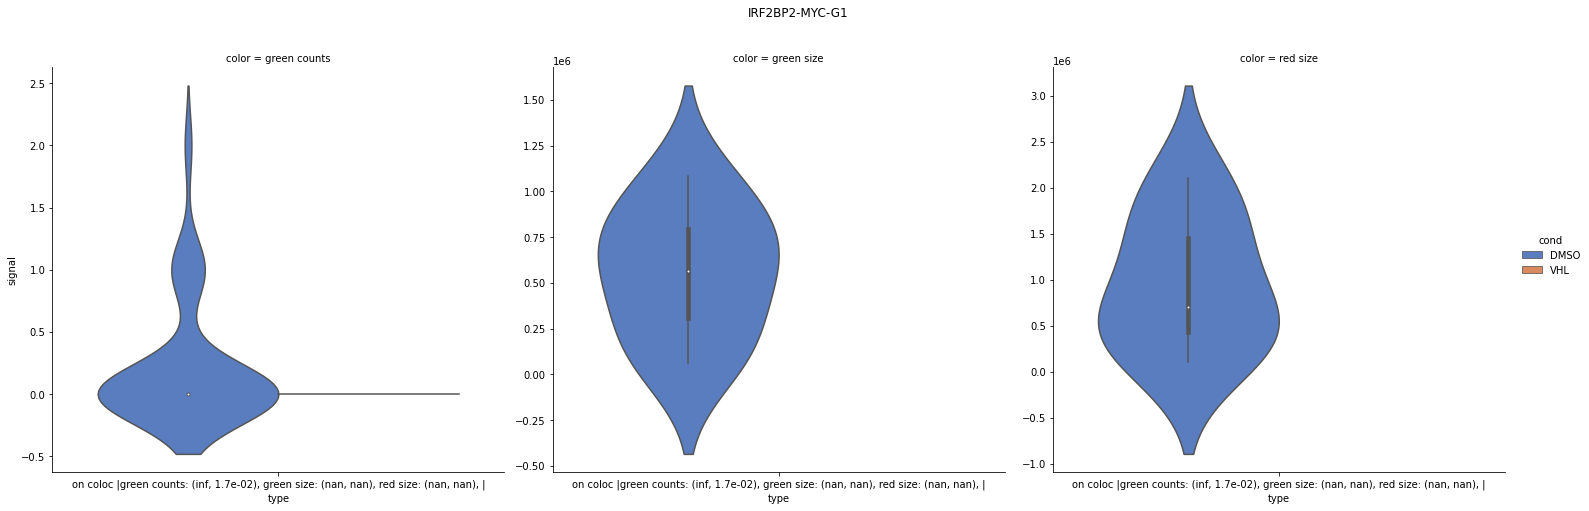

In [713]:
for k, val in data.items():
    g = sns.catplot(kind="violin", x="type", y="signal", hue="cond", col="color", data=val, palette="muted", sharey=False, height=7)
    g.fig.subplots_adjust(top=0.86)
    g.fig.suptitle(k)
    plt.show()
    g.savefig(folder+k+"_violin_oncobinding.pdf")

### on all

In [714]:
# compute difference in number/surface/max/min/mean(val) of green /red across cells and cobindings
data = {}
typ = [("sum_green_sum", "green sum"), ('sum_red_sum', "red sum"), ('mean_red_mean', "red mean"), ('mean_green_mean', "green mean"), ("area_sum", "size")]
for k in set(mdots.exp):
    print(k)
    print('______________________________\n')
    at = pd.DataFrame()
    
    for t in ['DMSO', 'VHL']:
        print(t)
        d = mdots[(mdots.exp==k)&(mdots.treat==t)]
        
        # counts per cell
        a = pd.DataFrame()
        b = pd.DataFrame()
        print("\ncount greens per cell:")
        e = [len(d[(d["group"]==cell)&(d['class']=="green")]) for cell in set(d.group)]
        print(min(e))
        print(np.mean(e), np.sqrt(np.var(e)))
        
        b["color"] = ['on green']*len(e)
        b['signal'] = e
        a = a.append(b)
        
        b = pd.DataFrame()
        e = [len(d[(d["group"]==cell)&(d['class']=="red")]) for cell in set(d.group)]
        b["color"] = ['on red']*len(e)
        b['signal'] = e
        a = a.append(b)
        
        b = pd.DataFrame()
        e = [len(d[(d["group"]==cell)&(d['class']=="cobinding")]) for cell in set(d.group)]
        b["color"] = ['on coloc']*len(e)
        b['signal'] = e
        a = a.append(b)
        
        a['type'] = "counts"
        a['cond'] = t
        at = at.append(a)
        
        # TOTAL signal
        
        b = pd.DataFrame()
        print("\ntotal signal greens per cell:")
        e = [sum(d[(d["group"]==cell)&(d['class']=="green")]['sum_green_sum']) for cell in set(d.group)]
        print(min(e))
        print(np.mean(e), np.sqrt(np.var(e)))
        
        b["color"] = ['on green']*len(e)
        b['signal'] = e
        a.append(b)
        
        b = pd.DataFrame()
        e = [sum(d[(d["group"]==cell)&(d['class']=="red")]['sum_red_sum']) for cell in set(d.group)]
        b["color"] = ['on red']*len(e)
        b['signal'] = e
        a = a.append(b)
        
        b = pd.DataFrame()
        e = [sum(d[(d["group"]==cell)&(d['class']=="cobinding")]['sum_green_sum']) for cell in set(d.group)]
        b["color"] = ['on coloc']*len(e)
        b['signal'] = e
        a.append(b)
        
        a['type'] = "total sum"
        a['cond'] = t
        at = at.append(a)
        
        for (col,name) in typ:
            print(name)
            a = pd.DataFrame()
            print('\nsignal in green:')
            e = d[d['class']=="green"][col].tolist()
            print(np.mean(e), np.sqrt(np.var(e)))
            b = pd.DataFrame()
            b['signal'] = e
            b['color'] = "on green"
            a = a.append(b)
            
            print('\nsignal in red:')
            e = d[d['class']=="red"][col].tolist()
            print(np.mean(e), np.sqrt(np.var(e)))
            
            b = pd.DataFrame()
            b['signal'] =  e
            b['color'] = "on red"
            a = a.append(b)

            print('\nsignal in cobinding:')
            e = d[d['class']=="cobinding"][col].tolist()
            print(np.mean(e), np.sqrt(np.var(e)))
            
            b = pd.DataFrame()
            b['signal'] = e
            b['color'] = "on coloc"           
            print('\n\n')
            a = a.append(b)
            a['type']=name
            a['cond'] = t
            at = at.append(a)
        print('____________\n')
    data[k] = at.reset_index(drop=True)
    
# adding chi2
for k,val in data.items():
    for i in set(val['type']):
        e = " |"
        for u in ['on green', "on red", "on coloc"]:#set(val['color']):
            a = val[(val['type'] == i) & (val['color'] == u) & (val['cond'] == "DMSO")]["signal"].tolist()
            b = val[(val['type'] == i) & (val['color'] == u) & (val['cond'] == "VHL")]["signal"].tolist()
            r = ttest_ind(a, b, equal_var=False)
            e+= u + ": ("f"{np.mean(a)/np.mean(b):.1f}, "f"{r[1]:.1e}), "
        val.loc[val[val['type'] == i].index, 'type'] = i + e +"|"
    data[k] = val

IRF2BP2-MYC-G1
______________________________

DMSO

count greens per cell:
13
139.0 79.6849858486338

total signal greens per cell:
2151060.0
64758408.121212125 53392782.18108364
green sum

signal in green:
465887.82821015915 672403.921155853

signal in red:
162218.2 239049.1439311096

signal in cobinding:
2669355.285714286 1481155.3393358379



red sum

signal in green:
111873.56354916067 475042.22565486305

signal in red:
3496438.4545454546 4814569.330559763

signal in cobinding:
9197765.714285715 6666746.168277781



red mean

signal in green:
460.80034909525295 664.7057629666382

signal in red:
5461.535688554924 1824.584995333146

signal in cobinding:
5475.0334444066775 1537.3063810184092



green mean

signal in green:
1945.7323357881573 478.38601356401716

signal in red:
316.41372330566463 281.67978417637994

signal in cobinding:
1698.4072144900176 394.491297989115



size

signal in green:
201207.27512535427 216324.82307015368

signal in red:
531301.6363636364 569005.3448809634

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-714-a0399e1665f2>:112: RuntimeWarning: divide by zero encountered in double_scalars
  e+= u + ": ("f"{np.mean(a

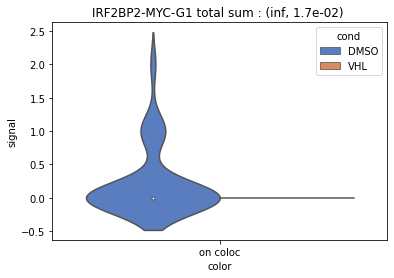

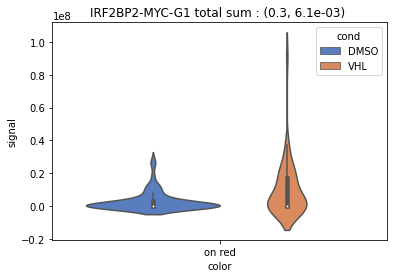

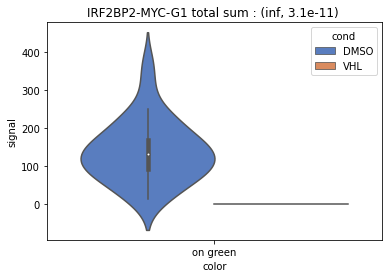

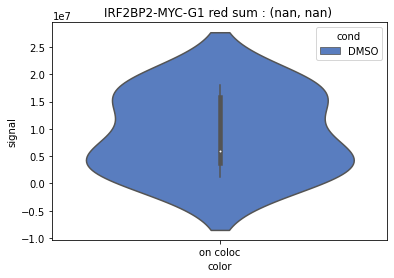

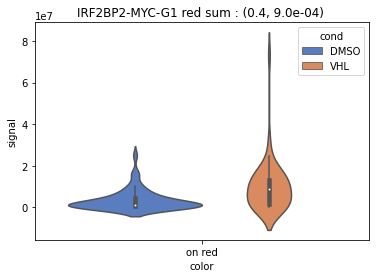

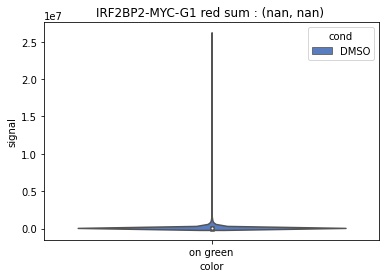

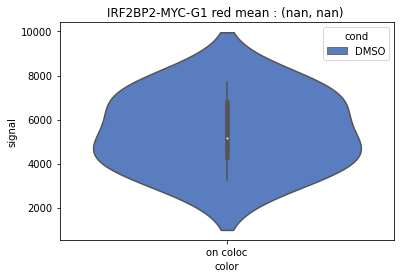

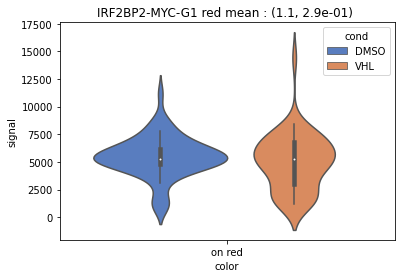

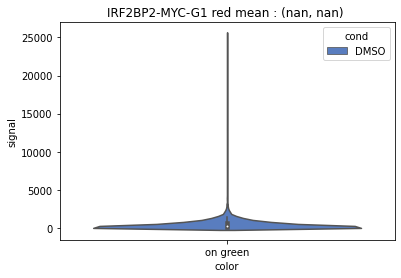

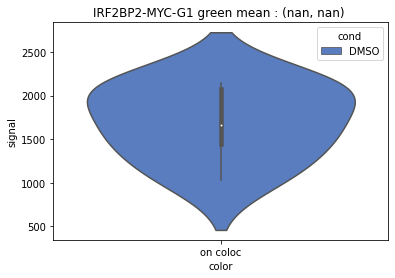

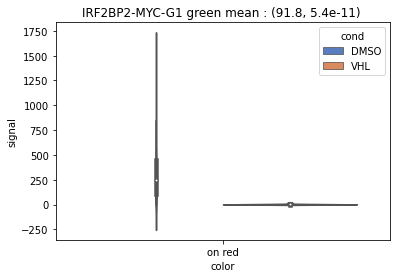

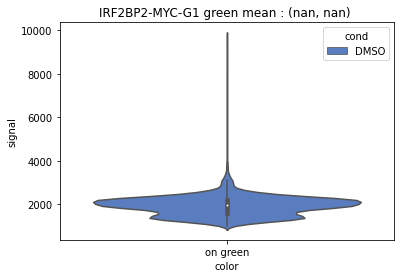

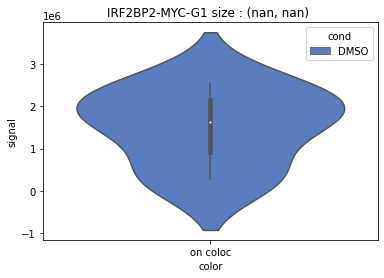

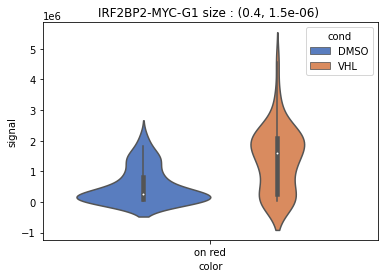

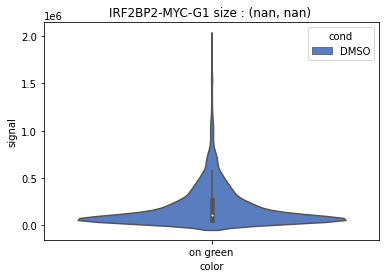

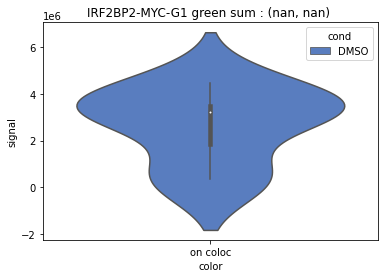

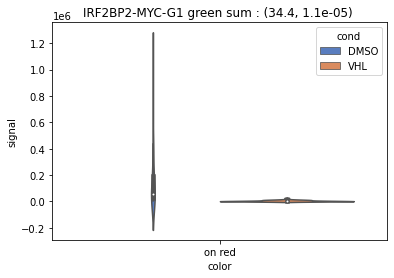

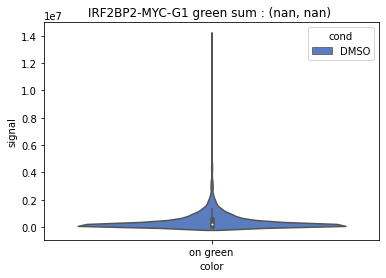

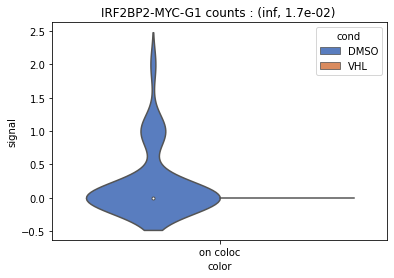

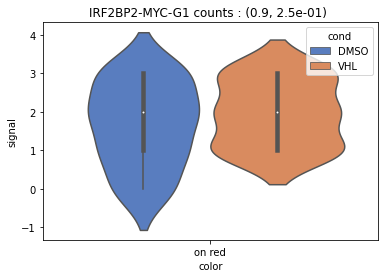

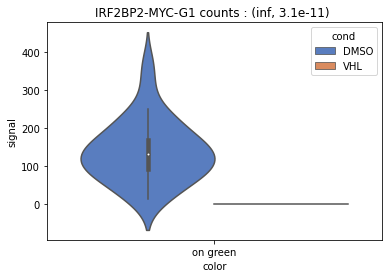

In [715]:
for k, v in data.items():
    for l in set(v['type']):
        for m in set(v['color']):
            try:
                ax = sns.violinplot(data = v[(v['type']==l)&(v['color']==m)], x="color", y="signal", hue="cond", palette="muted")
            except ValueError:
                print('no data to plot that one')
                continue
            plt.title(k+" "+l.split('|')[0]+""+l.split(m)[-1].split('),')[0]+") ")
            
            plt.show()
            
            ax.get_figure().savefig(folder+k+'_single_'+l.split(' |')[0]+"_"+m+".pdf")

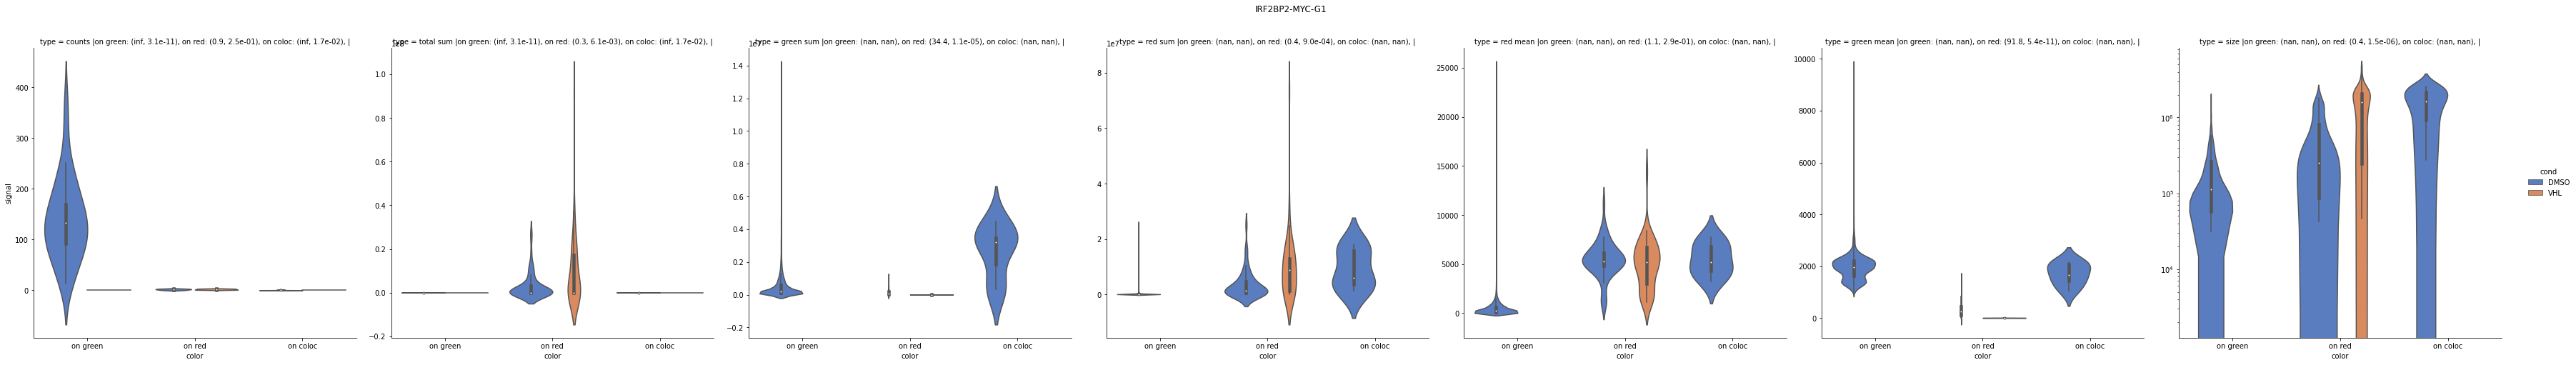

In [716]:
for k, val in data.items():
    g = sns.catplot(kind="violin", x="color", y="signal", hue="cond", col="type", data=val, palette="muted", sharey=False, height=7)
    g.fig.subplots_adjust(top=0.86)
    g.fig.suptitle(k)
    plt.yscale('log')
    plt.show()
    g.savefig(folder+k+"_violin_all.pdf")

/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:15: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  warn((
/home/jeremie/.local/lib/python3.8/site-packages/venn/_backwards_compatibility.py:30: UserWarning: `venn2()` is retained for backwards compatibility; use `venn()` instead
  warn((


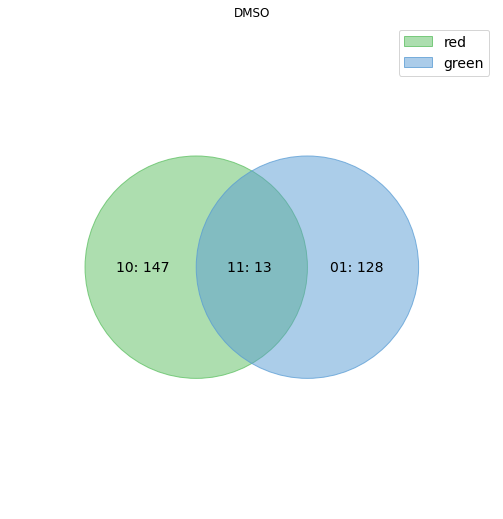

<Figure size 432x288 with 0 Axes>

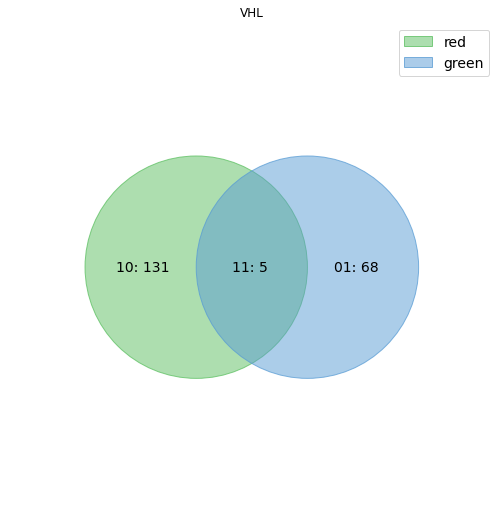

<Figure size 432x288 with 0 Axes>

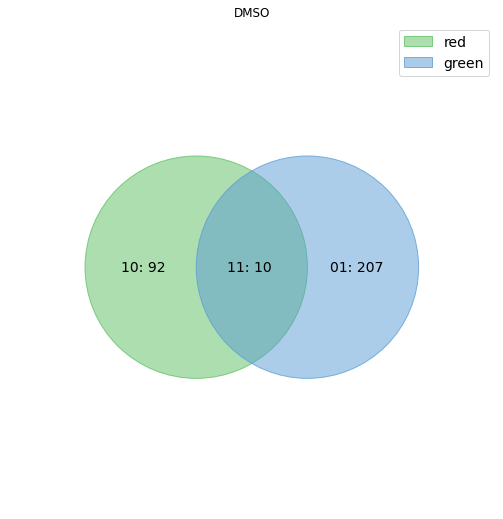

<Figure size 432x288 with 0 Axes>

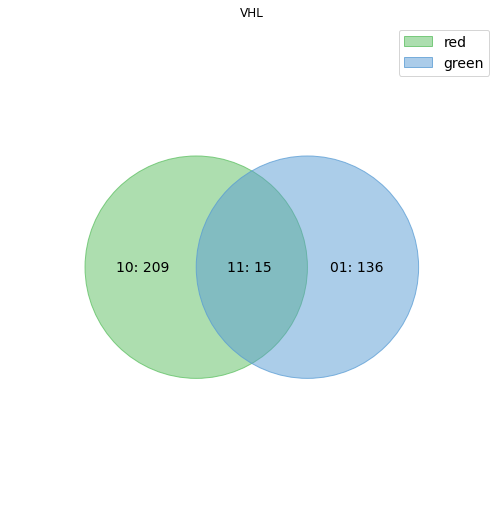

In [411]:
for val in ['MEF2D-MEF2C-G2','MEF2D-MEF2C-G1']:
    a = data[val]
    for v in ['DMSO','VHL']:
        f = int(a[(a.color=="on green")&(a.cond==v)&(a.type.str.contains('counts'))].signal.mean())
        e = int(a[(a.color=="on red")&(a.cond==v)&(a.type.str.contains('counts'))].signal.mean())
        i = int(a[(a.color=="on coloc")&(a.cond==v)&(a.type.str.contains('counts'))].signal.mean())
        c = f
        f = [u for u in range(f)]
        pe = [u for u in range(c, e+c)]
        c+=e
        e=pe
        e.extend([u for u in range(c, c+i)])
        f.extend([u for u in range(c, c+i)])
        plot.venn([set(e),set(f)], ["red", "green"], title=v)
        plt.savefig(folder+'MEF2D-MEF2C_venn'+v+'_mean_percell.pdf')

## likelyhood of coloc compared to expectation for each experiment &  between conditions

In [723]:
# compute dot likelyhood of coloc compared to expectation for each experiment &  between conditions
enrichment = {}

for k in set(mdots.exp):
    count = []
    fisher = []
    print('______________________________')
    print(k)
    for e in ['DMSO', 'VHL']:
        d = mdots[(mdots.exp==k)&(mdots.treat==e)]
        allredcount = len(d[d['class']!="green"])
        try:
            obs_cob = len(d[d['class']=="cobinding"])/allredcount
        except ZeroDivisionError:
            print('no red dot')
            continue
        obs_green = d[d['class']=="green"].area_sum.sum() * call_scale
        pred_cob = obs_green / mcells[(mcells.exp==k)&(mcells.treat==e)].area_sum.sum()
        #print(obs_cob, obs_green, pred_cob)
        count.append(obs_cob/pred_cob)
        print(e+": "+str(obs_cob/pred_cob))
        a = pred_cob*allredcount
        b = obs_cob*allredcount
        f = fisher_exact(np.array([[b, allredcount - b], [a, allredcount - a]], dtype=int))
        if f[0] is np.inf:
            f = (obs_cob/pred_cob, f[1])
        fisher.append(f)
    enrichment[k] = fisher
    print("change: "+str(count[1]/count[0]))

______________________________
IRF2BP2-MYC-G1
DMSO: 26.394364161375105
VHL: nan
change: nan


<ipython-input-723-ed259571b9b8>:20: RuntimeWarning: invalid value encountered in double_scalars
  count.append(obs_cob/pred_cob)
<ipython-input-723-ed259571b9b8>:21: RuntimeWarning: invalid value encountered in double_scalars
  print(e+": "+str(obs_cob/pred_cob))


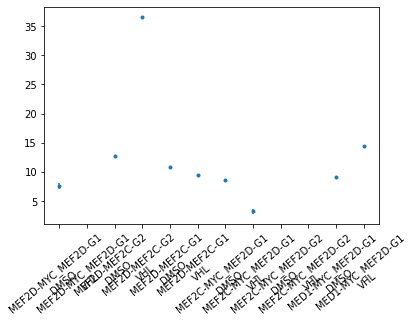

In [720]:
x=[]
y=[]
e=[]
for k, val in enrichment.items():
    x.append(k+'\nDMSO')
    y.append(val[0][0])
    e.append(val[0][1])
    x.append(k+'\nVHL')
    y.append(val[1][0])
    e.append(val[1][1])
plt.errorbar(x, y, e, linestyle='None', marker='.')
plt.xticks(rotation = 40) # Rotates X-Axis Ticks by 45-degrees
plt.savefig(folder+"_"+version+'_enrichments.pdf')

## plot of averaged binned signal by distance from focis

In [745]:
# make a plot of averaged binned signal strength by distance from locis
twodists, dists = fish.computeDistsFromClass(agreen[agreen.exp.str.contains("MED1-MYC_MEF2D-G1")], mred[mred.exp.str.contains("MED1-MYC_MEF2D-G1")], conds=['DMSO', 'VHL'], groupcol="group", sclass='green', signal="mean_green", area="area")

MED1-MYC_MEF2D-G1 DMSO
MED1-MYC_MEF2D-G1 VHL


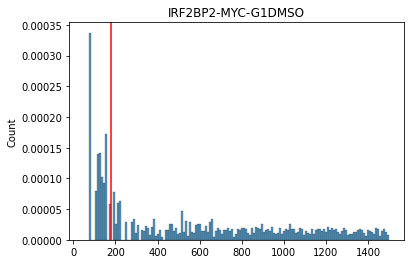

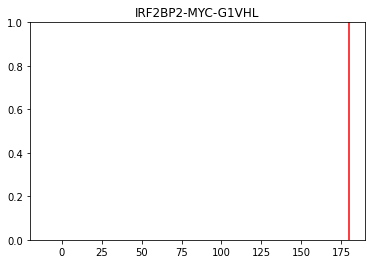

In [722]:
size=1500
bins = 150
defa = size/bins
for k, v in dists.items():
    plt.title(k)
    scale = ((4.19*(defa+v[0][v[0]<size]))**3)-((4.19*(v[0][v[0]<size]))**3)
    ax = sns.histplot(x=v[0][v[0]<size], weights=v[1][v[0]<size]/scale, bins=bins, fill=True)
    plt.axvline(x=180, color="red")
    ax.set(xlim=(-20,None))
    plt.show()
    ax.get_figure().savefig(folder+k+'_1D_distances_from_red.pdf')

In [587]:
norm = {'MED1-MYC_MEF2D-G1':(2000,5000), 
        'MED1-MYC_MEF2D-G2':(2000,5000),
        'MEF2C-MYC_MEF2D-G2':(2000,5000),
        'MEF2C-MYC_MEF2D-G1':(2000,5000),
        'MEF2D-MYC_MEF2D-G1':(2000,5000)
       }

In [725]:
twodists.keys()

dict_keys(['IRF2BP2-MYC-G1DMSO', 'IRF2BP2-MYC-G1VHL'])

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


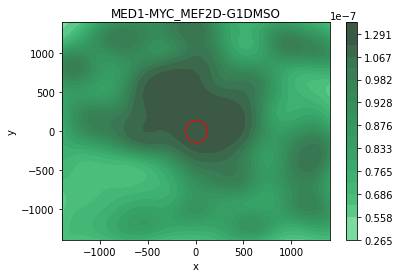

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


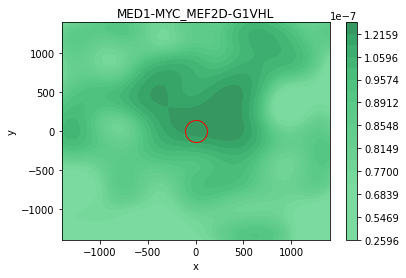

In [754]:
for k in ['MED1-MYC_MEF2D-G1','IRF2BP2-MYC-G']:#,'MEF2C-MYC_MEF2D-G2','MEF2C-MYC_MEF2D-G1','MEF2D-MYC_MEF2D-G1']:
    fish.drawDots({i: twodists[i] for i in twodists.keys() if k in i}, scenter=22, size=1400, zsize=800, folder=folder+'greenall_', signal="mean_green",area="area", sizes=(100,250), alpha=0.1, levels=20, vmin=0.5e-7, vmax=1.2e-7,)#second=lambda x: x.index.isin(adots[adots.index.isin(x.index.tolist()) & adots.m_id.isin(mdots[mdots['class'] == "cobinding"].index)].index))

In [ ]:
ls 

In [731]:
norm = {'MED1-MYC_MEF2D-G1':(1000,5000), 
        'MED1-MYC_MEF2D-G2':(2000,5000),
        'MEF2C-MYC_MEF2D-G2':(2000,5000),
        'MEF2C-MYC_MEF2D-G1':(2000,5000),
        'MEF2D-MYC_MEF2D-G1':(2000,5000)
       }

<Figure size 432x288 with 0 Axes>

In [483]:
for k in ['MED1-MYC_MEF2D-G1','MED1-MYC_MEF2D-G2','MEF2C-MYC_MEF2D-G2','MEF2C-MYC_MEF2D-G1','MEF2D-MYC_MEF2D-G1']:
    fish.drawDots({i: twodists[i] for i in twodists.keys() if k in i}, scenter=85, size=400, zsize=600, folder=folder+'coloconly_', signal="mean_green", area="area", sizes=(400,850), palette=sns.light_palette("orange", as_cmap=True), alpha=0.4, norm=norm[k])

KeyError: 'mean_green'

In [474]:
# make a plot of averaged binned signal strength by distance from locis
twodists, _ = fish.computeDistsFromClass(ared[~ared.group.str.contains("MEF2D-MEF2C")], mred[~mred.group.str.contains("MEF2D-MEF2C")], conds=['DMSO', 'VHL'], groupcol="group", sclass='red', signal="mean_red", area="area")

MEF2D-MYC_MEF2D-G1 DMSO
MEF2D-MYC_MEF2D-G1 VHL
MEF2C-MYC_MEF2D-G2 DMSO
MEF2C-MYC_MEF2D-G2 VHL
MED1-MYC_MEF2D-G1 DMSO
MED1-MYC_MEF2D-G1 VHL
MEF2C-MYC_MEF2D-G1 DMSO
MEF2C-MYC_MEF2D-G1 VHL


In [479]:
norm = {'MED1-MYC_MEF2D-G1':(2000,15000), 
        'MED1-MYC_MEF2D-G2':(4000,20000),
        'MEF2C-MYC_MEF2D-G2':(4000,20000),
        'MEF2C-MYC_MEF2D-G1':(4000,20000),
        'MEF2D-MYC_MEF2D-G1':(2000,8000)
       }

<Figure size 432x288 with 0 Axes>

In [637]:
for k in ['MED1-MYC_MEF2D-G1','MED1-MYC_MEF2D-G2','MEF2C-MYC_MEF2D-G2','MEF2C-MYC_MEF2D-G1','MEF2D-MYC_MEF2D-G1']:
    fish.drawDots({i: twodists[i] for i in twodists.keys() if k in i}, scenter=75, size=400, zsize=600, folder=folder+'redonly', signal="mean_red", area="area", sizes=(400,850), palette=sns.light_palette("red", as_cmap=True), alpha=0.05, norm=norm[k])

KeyError: "['mean_red'] not in index"

In [ ]:
size=400
lim = 100
bins=60
s = 25
maxv=10
for k in ['MED1-MYC_MEF2D-G1','MED1-MYC_MEF2D-G2','MEF2C-MYC_MEF2D-G2','MEF2C-MYC_MEF2D-G1','MEF2D-MYC_MEF2D-G1']:
    for u, v in {i: twodists[i] for i in twodists.keys() if k in i}.items():
        p = sns.jointplot(data=v[(abs(v.x)<size) & (abs(v.y)<size)], x="x", y="y",  kind="hex", color="red", joint_kws={'weights':"mean_red"}, xlim=(-lim,lim), ylim=(-lim,lim), gridsize=bins, vmax=maxv)
        p.plot_marginals(sns.distplot, rug=True, hist_kws={"range":(0,maxv)})
        p.plot_joint(sns.kdeplot, color="black", xlim=(-lim,lim), ylim=(-lim,lim), weights="mean_red", linewidth=1, alpha=.5)

        # gridsize=50, kind="hex", marginal_kws=dict(bins=50))
        # hue="sum_green_sum")
        x_values = [0]#, 2, 3, 4]
        y_values = [0]#, 0, 0, 0]
        #p.ax_joint.plot(x_values, y_values, 'o', ms=s, markerfacecolor="None",
        #    markeredgecolor='white', markeredgewidth=1)
        p.fig.suptitle(u)
        plt.show()
    
        p.savefig(folder+u+'_2D_distances_from_red.pdf')
    break

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'xlim', 'ylim', 'linewidth'
  cset = contour_func(


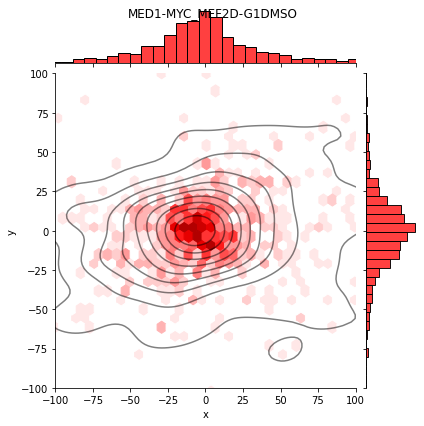

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'xlim', 'ylim', 'linewidth'
  cset = contour_func(


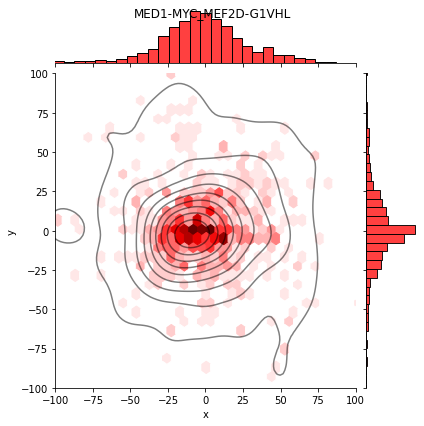

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'xlim', 'ylim', 'linewidth'
  cset = contour_func(


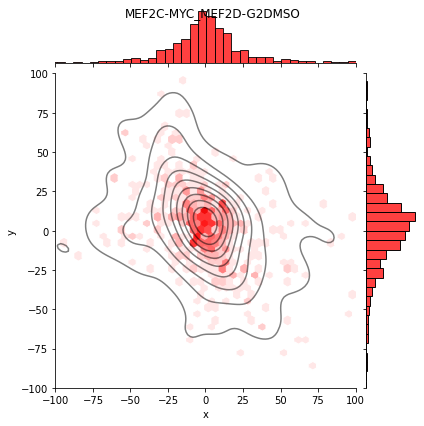

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'xlim', 'ylim', 'linewidth'
  cset = contour_func(


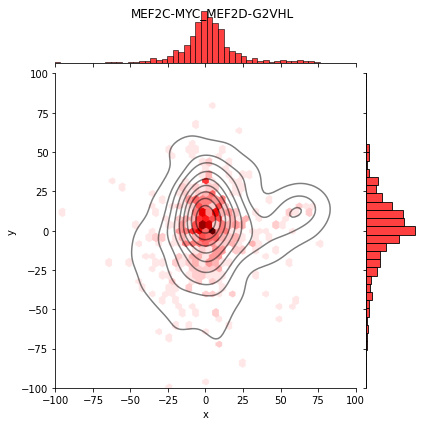

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'xlim', 'ylim', 'linewidth'
  cset = contour_func(


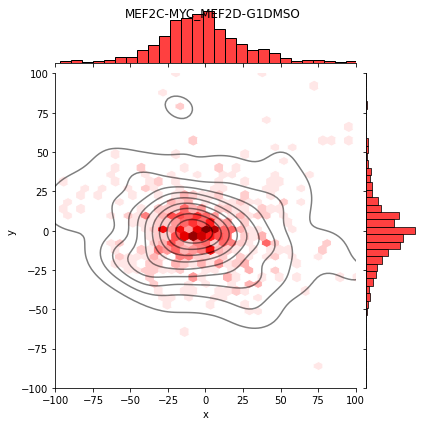

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'xlim', 'ylim', 'linewidth'
  cset = contour_func(


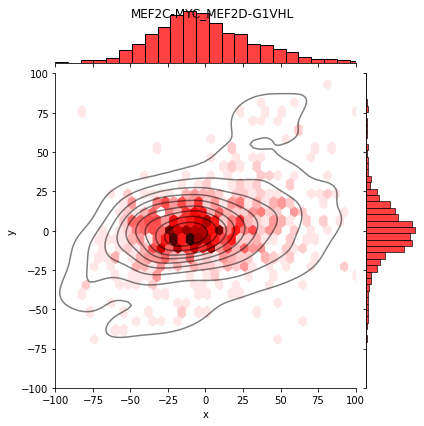

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'xlim', 'ylim', 'linewidth'
  cset = contour_func(


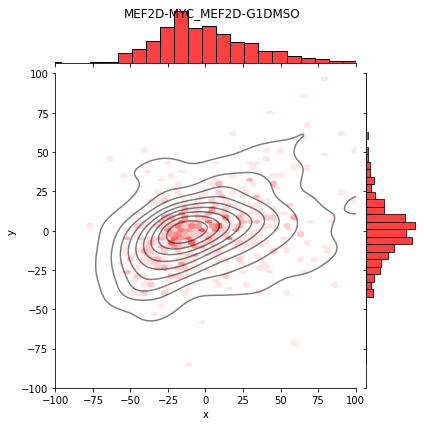

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'xlim', 'ylim', 'linewidth'
  cset = contour_func(


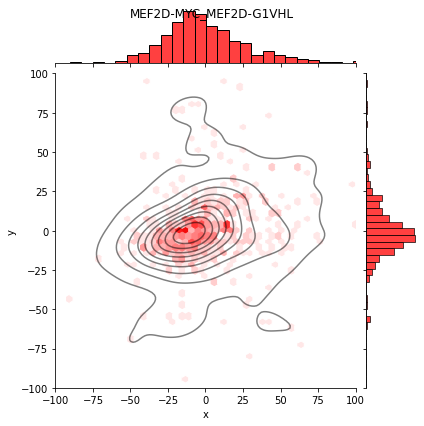

In [584]:
size=200
lim = 100
bins=60
s = 25
for k in ['MED1-MYC_MEF2D-G1','MED1-MYC_MEF2D-G2','MEF2C-MYC_MEF2D-G2','MEF2C-MYC_MEF2D-G1','MEF2D-MYC_MEF2D-G1']:
    for u, v in {i: twodists[i] for i in twodists.keys() if k in i}.items():
        p = sns.jointplot(data=v[(abs(v.x)<size) & (abs(v.y)<size)], x="x", y="y",  kind="hex", color="red",  xlim=(-lim,lim), ylim=(-lim,lim), gridsize=bins, vmin=0, vmax=20)
        sns.kdeplot(data=v[(abs(v.x)<size) & (abs(v.y)<size)][["x",'y','mean_red']].astype(float), x="x", y="y", color="black", xlim=(-lim,lim), ylim=(-lim,lim), weights="mean_red", linewidth=1, alpha=.5)

        # gridsize=50, kind="hex", marginal_kws=dict(bins=50))
        # hue="sum_green_sum")
        x_values = [0]#, 2, 3, 4]
        y_values = [0]#, 0, 0, 0]
        #p.ax_joint.plot(x_values, y_values, 'o', ms=s, markerfacecolor="None",
        #    markeredgecolor='white', markeredgewidth=1)
        p.fig.suptitle(u)
        plt.show()
    
        p.savefig(folder+u+'_2D_distances_from_red.pdf')

In [585]:
# apply plot to old data from juliana    

In [ ]:
# make a nice fake plot
sns.plot()

In [194]:
mv $folder '../results/FishSuperResColoc/plots_v3_withfilter/'

## saving

In [200]:
! cd .. && git add . && git commit -m "adding whiskers" && git push

[master a1525e5] adding whiskers
 292 files changed, 324615 insertions(+), 10805 deletions(-)
 rewrite notebooks/Fish_SuperRes.ipynb (66%)
 create mode 100644 results/FishSuperResColoc/plots_v3_withfilter/MED1-MYC_MEF2DDMSO_1D_distances_from_red.pdf
 create mode 100644 results/FishSuperResColoc/plots_v3_withfilter/MED1-MYC_MEF2DDMSO_2D_distances_from_red.pdf
 create mode 100644 results/FishSuperResColoc/plots_v3_withfilter/MED1-MYC_MEF2DDMSO_scatter_representation_size_to_center.pdf
 create mode 100644 results/FishSuperResColoc/plots_v3_withfilter/MED1-MYC_MEF2DVHL_1D_distances_from_red.pdf
 create mode 100644 results/FishSuperResColoc/plots_v3_withfilter/MED1-MYC_MEF2DVHL_2D_distances_from_red.pdf
 create mode 100644 results/FishSuperResColoc/plots_v3_withfilter/MED1-MYC_MEF2DVHL_scatter_representation_size_to_center.pdf
 create mode 100644 results/FishSuperResColoc/plots_v3_withfilter/MED1-MYC_MEF2D_single_counts _on coloc.pdf
 create mode 100644 results/FishSuperResColoc/plots_v3_wi

Enumerating objects: 233, done.
Counting objects: 100% (233/233), done.
Delta compression using up to 8 threads
Compressing objects: 100% (227/227), done.
Writing objects: 100% (227/227), 39.30 MiB | 4.56 MiB/s, done.
Total 227 (delta 196), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (196/196), completed with 4 local objects.
remote: warning: GH001: Large files detected. You may want to try Git Large File Storage - https://git-lfs.github.com.
remote: warning: See http://git.io/iEPt8g for more information.
remote: warning: File results/FishSuperResColoc/v3_annotated_green.csv is 85.88 MB; this is larger than GitHub's recommended maximum file size of 50.00 MB
remote: warning: File results/FishSuperResColoc/v3_all.csv is 99.44 MB; this is larger than GitHub's recommended maximum file size of 50.00 MB
remote: 
remote: GitHub found 1 vulnerability on jkobject/AMLproject's default branch (1 moderate). To find out more, visit:
remote:      https://github.com/jkobject/AMLp